In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from torch.utils.data import DataLoader, Subset

from datasets.embeddings_localization_dataset import EmbeddingsLocalizationDataset
from torchvision.transforms import transforms

from datasets.transforms import SolubilityToInt
from utils.general import numpy_collate_for_reduced
train_embeddings = 'data/embeddings/train_reduced.h5'
val_embeddings = 'data/embeddings/val_reduced.h5'
test_embeddings = 'data/embeddings/test_reduced.h5'
train_remapping = 'data/embeddings/train_remapped.fasta'
val_remapping = 'data/embeddings/val_remapped.fasta'
test_remapping = 'data/embeddings/test_remapped.fasta'
denovo_predictions = np.load('data/results/results_array_inference.npy')

In [2]:

transform = transforms.Compose([SolubilityToInt()])
train_set = EmbeddingsLocalizationDataset(train_embeddings, train_remapping, max_length=6000, transform=transform)
val_set = EmbeddingsLocalizationDataset(val_embeddings, val_remapping, transform=transform)

train_loader = DataLoader(train_set, batch_size=len(train_set), collate_fn=numpy_collate_for_reduced)
val_loader = DataLoader(val_set, batch_size=len(val_set), collate_fn=numpy_collate_for_reduced)

train_data = next(iter(train_loader))  # tuple of embedding, localization, solubility, metadata
val_data = next(iter(val_loader))  # tuple of embedding, localization, solubility, metadata
classifier = KNeighborsClassifier(n_neighbors=1, p=1)
#classifier = KNeighborsClassifier(n_neighbors=1, metric='cosine')
classifier.fit(train_data[0], train_data[1])


KNeighborsClassifier(n_neighbors=1, p=1)

In [3]:
predictions = classifier.predict(val_data[0])
distances, _ = classifier.kneighbors(val_data[0])
#distances = np.array(distances).sum(-1).squeeze()




In [4]:
import matplotlib
from torch.utils.data import DataLoader, Subset
import seaborn as sns
sns.set_theme()
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['savefig.dpi'] = 300

In [5]:
cutoffs = np.linspace(distances.min(),distances.max(),1000)
results = np.array([predictions,val_data[1], distances.squeeze()]).T


best_accuracy = 0
denovo_accuracies = []
knn_accuracies = []
accuracies = []
percentage_denovo = []
for cutoff in cutoffs:
    indices = results[:, 2] <= cutoff
    below_cutoff = results[indices]
    chosen_denovo_predictions = denovo_predictions[np.invert(indices)]
    knn_accuracies.append(100 * np.equal(below_cutoff[:, 0], below_cutoff[:, 1]).sum() / len(below_cutoff))
    denovo_accuracies.append(100 * np.equal(chosen_denovo_predictions[:, 0], chosen_denovo_predictions[:, 1]).sum() / len(chosen_denovo_predictions))
    combined_results = np.concatenate([chosen_denovo_predictions[:, :2], below_cutoff[:, :2]])
    accuracy = 100*np.equal(combined_results[:, 0], combined_results[:, 1]).sum() / len(combined_results)
    accuracies.append(accuracy)
    percentage_denovo.append(100*len(chosen_denovo_predictions)/len(results))
    if accuracy >= best_accuracy:
        best_accuracy = accuracy

print('only Light attention accuracy: ',100 * np.equal(denovo_predictions[:, 0], denovo_predictions[:, 1]).sum() / len(denovo_predictions))
print('best accuracy: ', best_accuracy)
best_accuracy_index = np.array(accuracies).argmax()
print('knn accuracy: ', knn_accuracies[best_accuracy_index])
print('denovo accuracy: ', denovo_accuracies[best_accuracy_index])
print('percentage of denovo predictions: ', percentage_denovo[best_accuracy_index])
print('best_distance_cutoff: ', cutoffs[best_accuracy_index])


only Light attention accuracy:  82.38341968911917
best accuracy:  84.1105354058722
knn accuracy:  98.14814814814815
denovo accuracy:  82.66666666666667
percentage of denovo predictions:  90.67357512953367
best_distance_cutoff:  7.46743061036162


<ipython-input-5-d520d91198fe>:15: RuntimeWarning: invalid value encountered in long_scalars
  denovo_accuracies.append(100 * np.equal(chosen_denovo_predictions[:, 0], chosen_denovo_predictions[:, 1]).sum() / len(chosen_denovo_predictions))


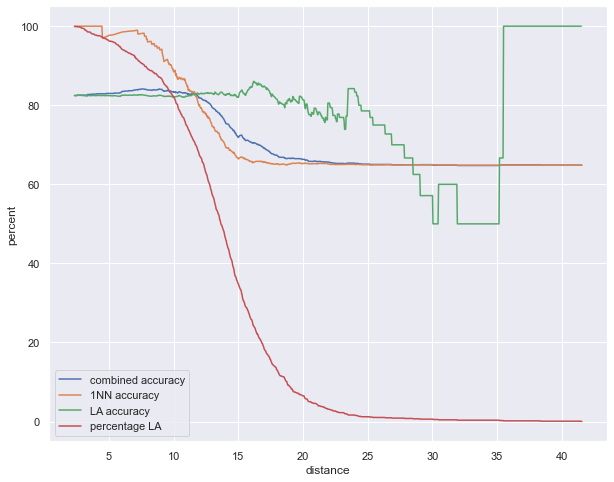

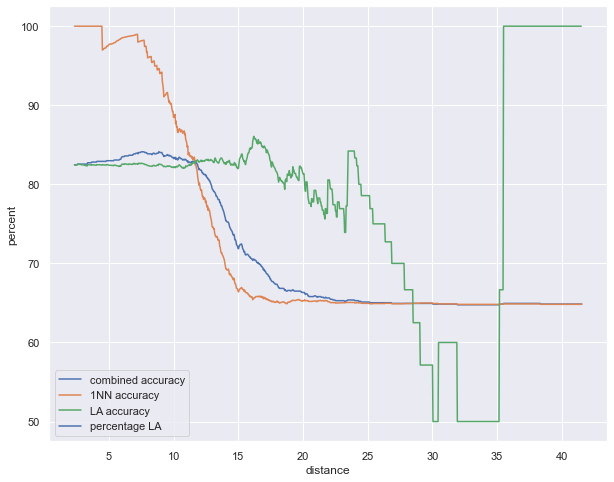

In [6]:
plt.rcParams['figure.figsize'] = [10, 8]
df = pd.DataFrame(np.array([cutoffs,accuracies, knn_accuracies, denovo_accuracies, percentage_denovo]).T,
                  columns=["distance", "accuracies", 'knn_accuracies', 'denovo_accuracies', 'percentage_denovo'])
df = df.melt('distance', var_name='cols',  value_name='percent')
sns.lineplot(x="distance", y="percent", hue='cols', data=df)
plt.legend(labels=['combined accuracy', '1NN accuracy', 'LA accuracy', 'percentage LA'])
plt.savefig('figure.png')
plt.show()
plt.clf()

df = pd.DataFrame(np.array([cutoffs,accuracies, knn_accuracies, denovo_accuracies]).T,
                  columns=["distance", "accuracies", 'knn_accuracies', 'denovo_accuracies'])
df = df.melt('distance', var_name='cols',  value_name='percent')
sns.lineplot(x="distance", y="percent", hue='cols', data=df)
plt.legend(labels=['combined accuracy', '1NN accuracy', 'LA accuracy', 'percentage LA'])
plt.savefig('figure2.png')


